In [21]:
import sys
sys.path.append("..")
from sklearn.datasets import load_wine
from deep_svdd import BaseSVDD
import os
import sys
import csv
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import glob
import cv2
from keras import layers
from sklearn.model_selection import train_test_split
from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.losses import mse
from keras import backend as K
from keras import models
from sklearn.svm import OneClassSVM
param = 2**(-6)

In [2]:
X_list = glob.glob('bottle/train/good/*.png')
Y_list1 = glob.glob('bottle/test/broken_large/*.png')
Y_list2 = glob.glob('bottle/test/broken_small/*.png')
Y_list3 = glob.glob('bottle/test/contamination/*.png')
Y_list4 = glob.glob('bottle/test/good/*.png')
X_train = None
X_test_good = None
X_test_error = None
for X_file in X_list:
  im = cv2.imread(X_file)
  im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
  im = cv2.resize(im, (256,256))
  im = im.reshape(1,im.shape[0],im.shape[1],im.shape[2])
  if X_train is not None:
    X_train = np.concatenate((X_train, im))
  if X_train is None:
    X_train = im

for Y_file in Y_list1:
  im = cv2.imread(Y_file)
  im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
  im = cv2.resize(im, (256,256))
  im = im.reshape(1,im.shape[0],im.shape[1],im.shape[2])
  if X_test_error is not None:
    X_test_error = np.concatenate((X_test_error, im))
  if X_test_error is None:
    X_test_error = im

for Y_file in Y_list2:
  im = cv2.imread(Y_file)
  im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
  im = cv2.resize(im, (256,256))
  im = im.reshape(1,im.shape[0],im.shape[1],im.shape[2])
  if X_test_error is not None:
    X_test_error = np.concatenate((X_test_error, im))
  if X_test_error is None:
    X_test_error = im

for Y_file in Y_list3:
  im = cv2.imread(Y_file)
  im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
  im = cv2.resize(im, (256,256))
  im = im.reshape(1,im.shape[0],im.shape[1],im.shape[2])
  if X_test_error is not None:
    X_test_error = np.concatenate((X_test_error, im))
  if X_test_error is None:
    X_test_error = im

for Y_file in Y_list4:
  im = cv2.imread(Y_file)
  im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
  im = cv2.resize(im, (256,256))
  im = im.reshape(1,im.shape[0],im.shape[1],im.shape[2])
  if X_test_good is not None:
    X_test_good = np.concatenate((X_test_good, im))
  if X_test_good is None:
    X_test_good = im

x_train, x_test = train_test_split(X_train, test_size=0.2)

image_size = x_train.shape[1] 
original_dim = image_size * image_size * 3
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

X_train = np.reshape(X_train, [-1, original_dim])
X_train = X_train.astype('float32') / 255

X_test_good = np.reshape(X_test_good, [-1, original_dim])
X_test_good = X_test_good.astype('float32') / 255

X_test_error = np.reshape(X_test_error, [-1, original_dim])
X_test_error = X_test_error.astype('float32') / 255
X_test = np.concatenate([X_test_good, X_test_error])

In [8]:
image_height, image_width = 256,256
model = models.Sequential()
model.add(layers.Dense(256, activation='relu',input_shape=(image_height * image_width*3,)))
model.add(layers.Dense(128,activation='relu'))
model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dense(32,activation='relu'))
model.add(layers.Dense(16,activation='relu'))
model.add(layers.Dense(32,activation='relu'))
model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dense(128,activation='relu'))
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(image_height * image_width*3,activation='relu'))
model.compile(optimizer='adam',loss='binary_crossentropy')
model.summary()

model.fit(X_train, X_train,epochs=10,batch_size=64,shuffle=True,validation_data=(x_test, x_test))
score = model.evaluate(x_test, x_test, verbose=0)
print('test xentropy:', score)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 256)               50331904  
                                                                 
 dense_11 (Dense)            (None, 128)               32896     
                                                                 
 dense_12 (Dense)            (None, 64)                8256      
                                                                 
 dense_13 (Dense)            (None, 32)                2080      
                                                                 
 dense_14 (Dense)            (None, 16)                528       
                                                                 
 dense_15 (Dense)            (None, 32)                544       
                                                                 
 dense_16 (Dense)            (None, 64)               

In [10]:
encoder = models.clone_model(model)
encoder.compile(optimizer='adam', loss='binary_crossentropy')
encoder.set_weights(model.get_weights())
for i in range(5):
    encoder.pop()
    
x_tr = encoder.predict(X_train,verbose=0)
x_tg = encoder.predict(X_test_good,verbose=0)
x_te = encoder.predict(X_test_error,verbose=0)



*** Fitting of the SVDD model is completed. ***

running time         = 0.0621 seconds
kernel function      = rbf
iterations           = 14
number of samples    = 209
number of features   = 16
number of SVs        = 65
ratio of SVs         = 31.1005 %
accuracy             = 86.6029 %




*** Prediction of the provided data is completed. ***

running time         = 0.0034 seconds
number of samples    = 209
number of alarm      = 28




*** Prediction of the provided data is completed. ***

running time         = 0.0020 seconds
number of samples    = 20
number of alarm      = 3




*** Prediction of the provided data is completed. ***

running time         = 0.0014 seconds
number of samples    = 63
number of alarm      = 17




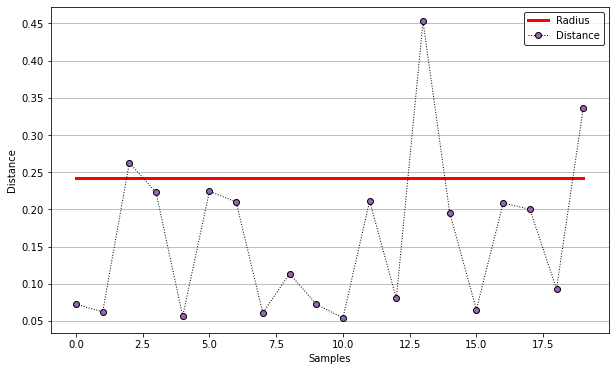

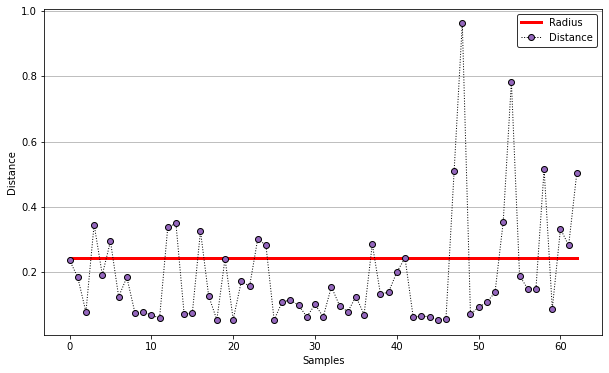

CPU times: total: 953 ms
Wall time: 400 ms


In [22]:
%%time
svdd = BaseSVDD(C=param, gamma=0.01,kernel='rbf', display='on')
svdd.fit(x_tr)
pre_t = svdd.predict(x_tr)
pre_g = svdd.predict(x_tg)
pre_e = svdd.predict(x_te)
radius = svdd.radius
distance = svdd.get_distance(x_tg)
svdd.plot_distance(radius, distance)
distance = svdd.get_distance(x_te)
svdd.plot_distance(radius, distance)

alphas = svdd.alpha
Param = svdd.C
# sv_list = svdd.support_vector_indices

In [23]:
m, n = x_tr.shape
SV = []
NSV = []
for i in range(m):
  if alphas[i] > 0 and alphas[i] <= Param[0]:
    SV.append(list(X_train[i, :]))
#   elif alphas[i] == Param:
#     SV.append(list(X_train[i, :, :, :]))
  else:
    NSV.append(list(X_train[i, :]))

sv = np.array(SV)
nsv = np.array(NSV)

model.fit(sv, sv,epochs=50,batch_size=32,shuffle=True,validation_data=(X_train, X_train))
score = model.evaluate(x_test, x_test, verbose=0)
print('test xentropy:', score)

Epoch 1/50
3/3 [==============================] - 3s 1s/step - loss: 1.6798 - val_loss: 1.6317
Epoch 2/50
3/3 [==============================] - 3s 1s/step - loss: 1.6242 - val_loss: 1.5735
Epoch 3/50
3/3 [==============================] - 3s 1s/step - loss: 1.5583 - val_loss: 1.4770
Epoch 4/50
3/3 [==============================] - 3s 1s/step - loss: 1.4611 - val_loss: 1.3960
Epoch 5/50
3/3 [==============================] - 3s 1s/step - loss: 1.3862 - val_loss: 1.3309
Epoch 6/50
3/3 [==============================] - 3s 1s/step - loss: 1.3184 - val_loss: 1.2699
Epoch 7/50
3/3 [==============================] - 3s 1s/step - loss: 1.2645 - val_loss: 1.2409
Epoch 8/50
3/3 [==============================] - 3s 1s/step - loss: 1.2356 - val_loss: 1.2096
Epoch 9/50
3/3 [==============================] - 3s 1s/step - loss: 1.2039 - val_loss: 1.1791
Epoch 10/50
3/3 [==============================] - 3s 1s/step - loss: 1.1753 - val_loss: 1.1513
Epoch 11/50
3/3 [==============================] 

In [24]:
encoder = models.clone_model(model)
encoder.compile(optimizer='adam',
                loss='binary_crossentropy')
encoder.set_weights(model.get_weights())
for i in range(4):
    encoder.pop()

X_tr = encoder.predict(X_train,verbose=0)
X_tg = encoder.predict(X_test_good,verbose=0)
X_te = encoder.predict(X_test_error,verbose=0)
# x_tr = np.reshape(X_tr,(X_tr.shape[0], X_tr.shape[1]*X_tr.shape[2]*X_tr.shape[3]))
# x_tg = np.reshape(X_tg,(X_tg.shape[0], X_tg.shape[1]*X_tg.shape[2]*X_tg.shape[3]))
# x_te = np.reshape(X_te,(X_te.shape[0], X_te.shape[1]*X_te.shape[2]*X_te.shape[3]))



*** Fitting of the SVDD model is completed. ***

running time         = 0.0589 seconds
kernel function      = rbf
iterations           = 14
number of samples    = 209
number of features   = 16
number of SVs        = 65
ratio of SVs         = 31.1005 %
accuracy             = 86.6029 %




*** Prediction of the provided data is completed. ***

running time         = 0.0000 seconds
number of samples    = 209
number of alarm      = 28




*** Prediction of the provided data is completed. ***

running time         = 0.0000 seconds
number of samples    = 20
number of alarm      = 3




*** Prediction of the provided data is completed. ***

running time         = 0.0156 seconds
number of samples    = 63
number of alarm      = 17




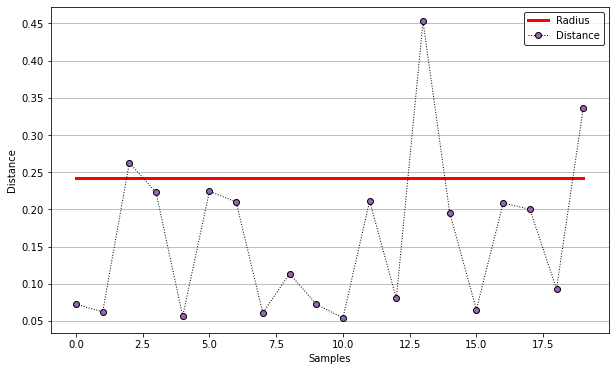

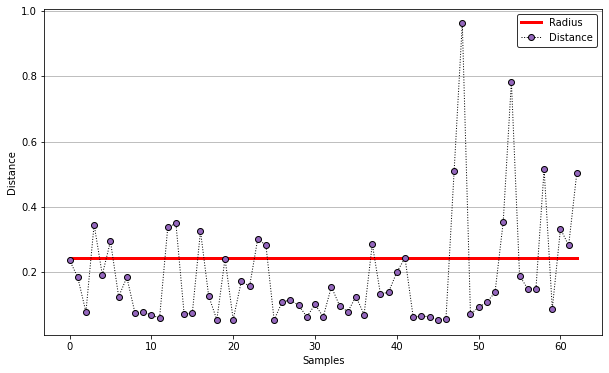

CPU times: total: 703 ms
Wall time: 441 ms


In [25]:
%%time
svdd = BaseSVDD(C=param, gamma=0.01, kernel='rbf', display='on')
svdd.fit(x_tr)
pre_t = svdd.predict(x_tr)
pre_g = svdd.predict(x_tg)
pre_e = svdd.predict(x_te)
radius = svdd.radius
distance = svdd.get_distance(x_tg)
svdd.plot_distance(radius, distance)
distance = svdd.get_distance(x_te)
svdd.plot_distance(radius, distance)

alphas = svdd.alpha
Param = svdd.C